# Challenge 3 : Team 50

## Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import warnings

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split

## Disable Warnings

In [2]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Data Loading

In [3]:
train_df = pd.read_csv('/kaggle/input/eurecom-aml-2021-challenge-3/train.csv')
test_df = pd.read_csv('/kaggle/input/eurecom-aml-2021-challenge-3/test.csv')

test_df["target"] = 1

In [5]:
target_conversion = {
    'negative': 0,
    'neutral': 1,
    'positive': 2,
}

class_names = ['negative', 'neutral', 'positive']

In [6]:
train_df['target'] = train_df['sentiment'].map(target_conversion)

# Setup

In [7]:
!pip install -qq transformers
!pip install watermark

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

import transformers
from transformers import BertModel, BertConfig, BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AutoModel, AutoTokenizer 
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.7.0
transformers: 4.5.1



# Data Exploration

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


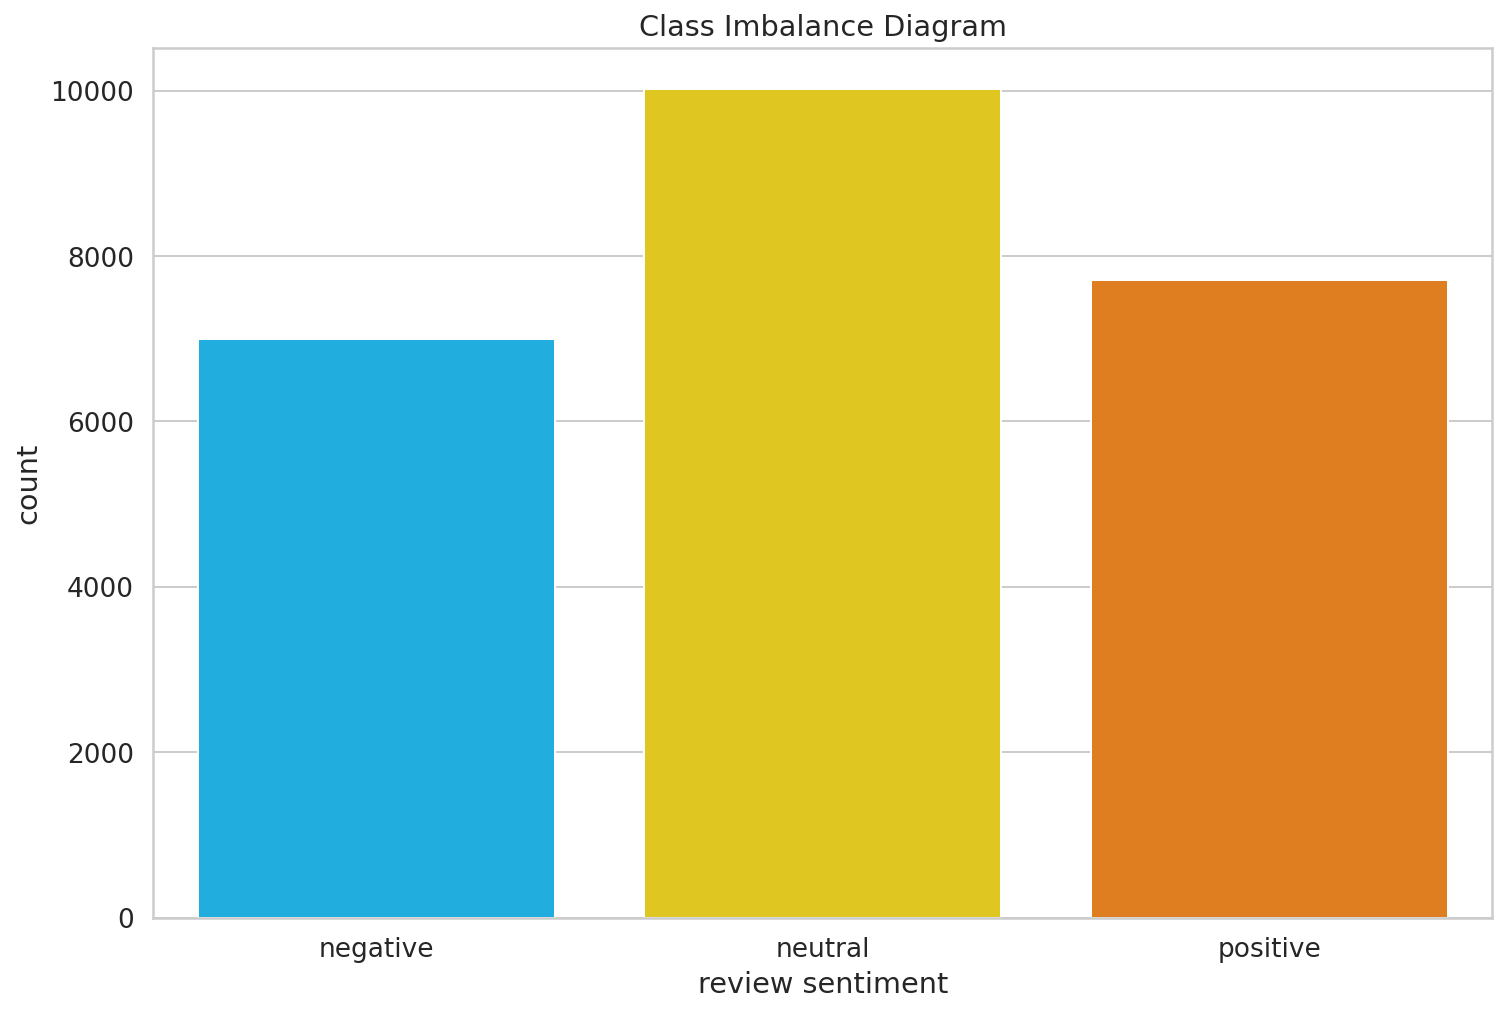

In [8]:
ax = sns.countplot(train_df.target)
plt.xlabel('review sentiment')
plt.title('Class Imbalance Diagram')
ax.set_xticklabels(class_names);

## Other visualizations

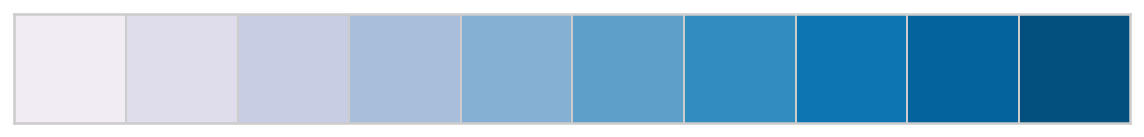

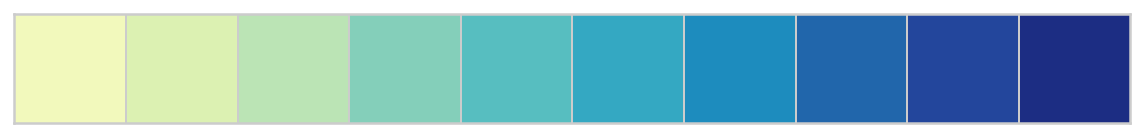

In [9]:
PuBu_palette = sns.color_palette("PuBu", 10)
YlGnBu_palette = sns.color_palette("YlGnBu", 10)
sns.palplot(PuBu_palette)
sns.palplot(YlGnBu_palette)

In [10]:
three_PuBu_palette = list()
three_PuBu_palette.append(PuBu_palette[2])
three_PuBu_palette.append(PuBu_palette[6])
three_PuBu_palette.append(PuBu_palette[4])
three_PuBu_palette

[(0.788558246828143, 0.8066897347174163, 0.8948558246828143),
 (0.19594002306805075, 0.5543713956170704, 0.7477739331026528),
 (0.5256439830834294, 0.691041906958862, 0.8287427912341407)]

In [11]:
def get_length_alphabets(text):
    text = str(text)
    return len(text)

In [12]:
def get_length_words(text):
    text = str(text)
    return len(text.split(' '))

In [13]:
train_df['length_alphabets'] = train_df['text'].apply(lambda x: get_length_alphabets(x))
train_df['length_words'] = train_df['text'].apply(lambda x: get_length_words(x))
train_df.head()

,textID,text,selected_text,sentiment,target,length_alphabets,length_words
0,28ac06f416,good luck with your auction,good luck with your auction,positive,2,28,6
1,92098cf9a7,Hmm..You can`t judge a book by looking at its ...,Hmm..You can`t judge a book by looking at its ...,neutral,1,51,10
2,7858ff28f2,"Hello, yourself. Enjoy London. Watch out for ...",They`re mental.,negative,0,75,12
3,b0c9c67f32,We can`t even call you from belgium sucks,m suck,negative,0,44,11
4,7b36e9e7a5,not so good mood..,not so good mood..,negative,0,18,4


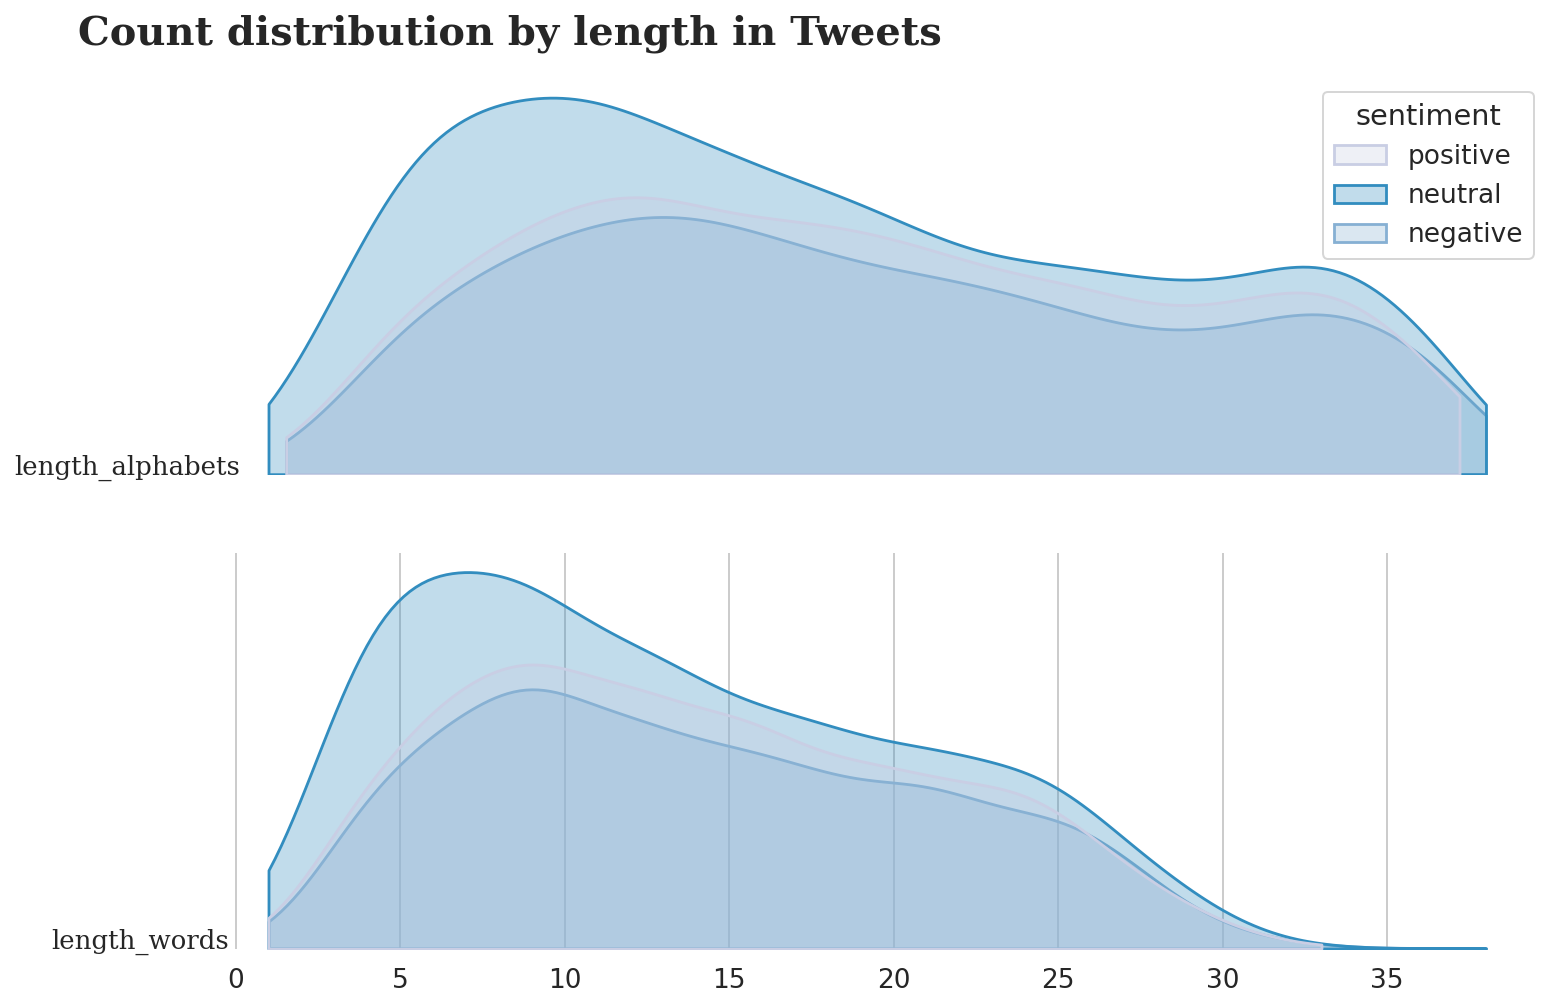

In [14]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2,1)

axes = list()

for index, data in zip(range(2), train_df):
    axes.append(fig.add_subplot(gs[index, 0]))
    
    
    if index==0:
        sns.kdeplot(x='length_alphabets', data=train_df, 
                        fill=True, ax=axes[index], cut=0, bw_method=0.20, 
                        lw=1.4 , hue='sentiment', palette=three_PuBu_palette,
                         alpha=0.3)
    else:
        sns.kdeplot(x='length_words', data=train_df, 
                    fill=True, ax=axes[index], cut=0, bw_method=0.20, 
                    lw=1.4 , hue='sentiment',palette=three_PuBu_palette,
                     alpha=0.3) 

    axes[index].set_yticks([])
    if index != 1 : axes[index].set_xticks([])
    axes[index].set_ylabel('')
    axes[index].set_xlabel('')
    axes[index].spines[["top","right","left","bottom"]].set_visible(False)
    
    
    if index == 0:
        axes[index].text(-0.2,0,"length_alphabets",fontweight="light", fontfamily='serif', fontsize=13,ha="right")
    else:
        axes[index].text(-0.2,0,"length_words",fontweight="light", fontfamily='serif', fontsize=13,ha="right")
        
        
    axes[index].patch.set_alpha(0)
    if index != 0 : axes[index].get_legend().remove()
        
fig.text(0.05,0.91,"Count distribution by length in Tweets", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

In [15]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

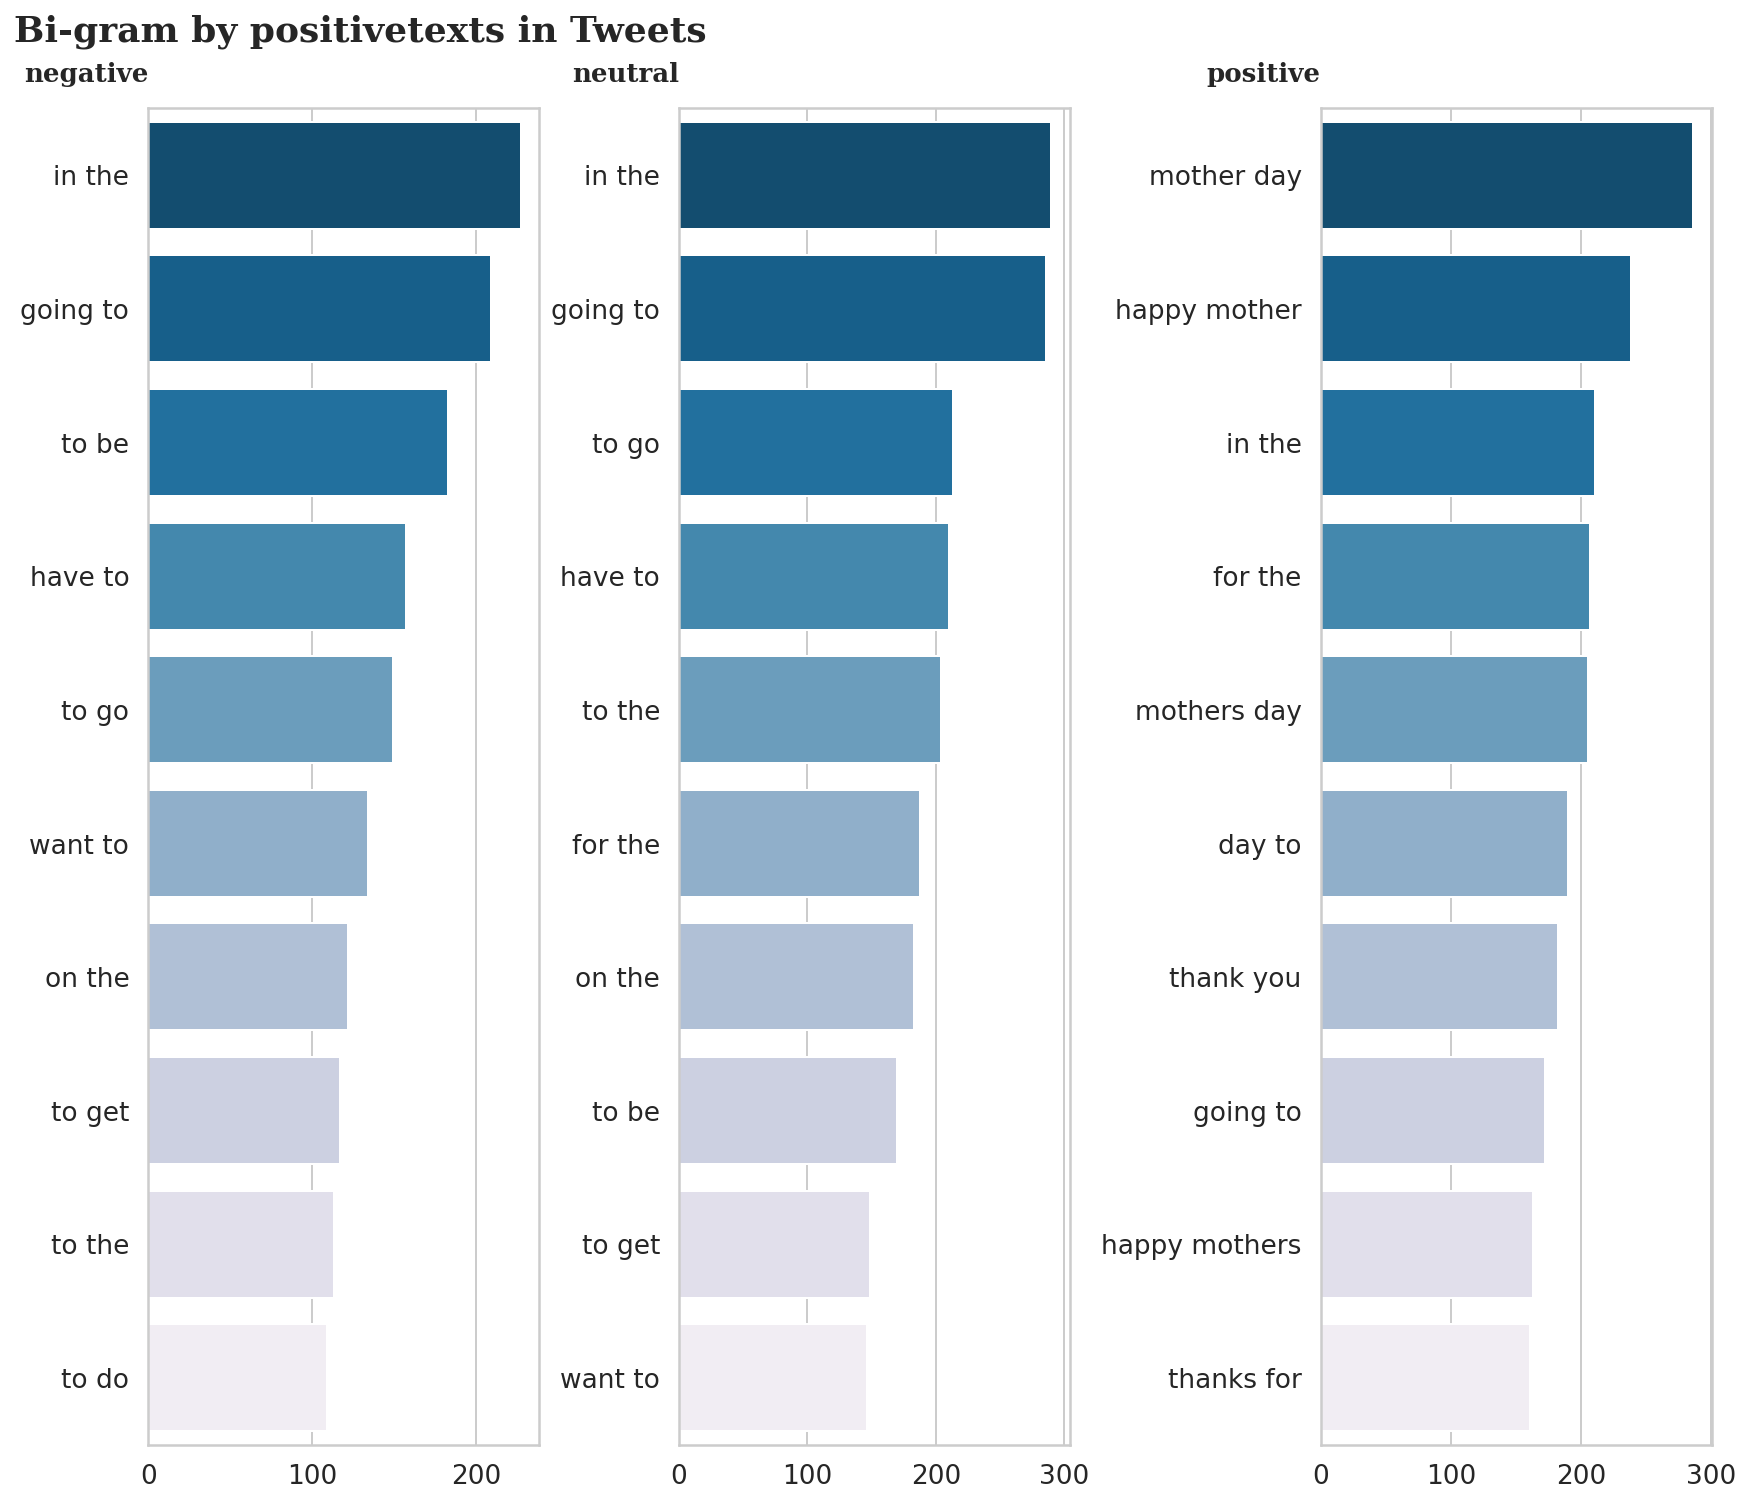

In [16]:
fig, axes = plt.subplots(1,3, figsize=(12, 10), constrained_layout=True)

sentiment_list = list(np.unique(train_df['sentiment']))

for i, sentiment in zip(range(3), sentiment_list):
    top_tweet_bigrams = get_top_tweet_bigrams(train_df[train_df['sentiment']==sentiment]['text'].fillna(" "))[:10]
    x,y = map(list,zip(*top_tweet_bigrams))
    sns.barplot(x=y, y=x, ax=axes[i], palette=PuBu_palette[::-1])
    axes[i].text(0,-0.7, sentiment, fontweight="bold", fontfamily='serif', fontsize=13,ha="right")
    axes[i].patch.set_alpha(0)

fig.text(0,1.01,"Bi-gram by {}texts in Tweets".format(sentiment), fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

In [17]:
from PIL import Image

mask_dir = np.array(Image.open('../input/twittermask/twitter_mask3.jpg'))

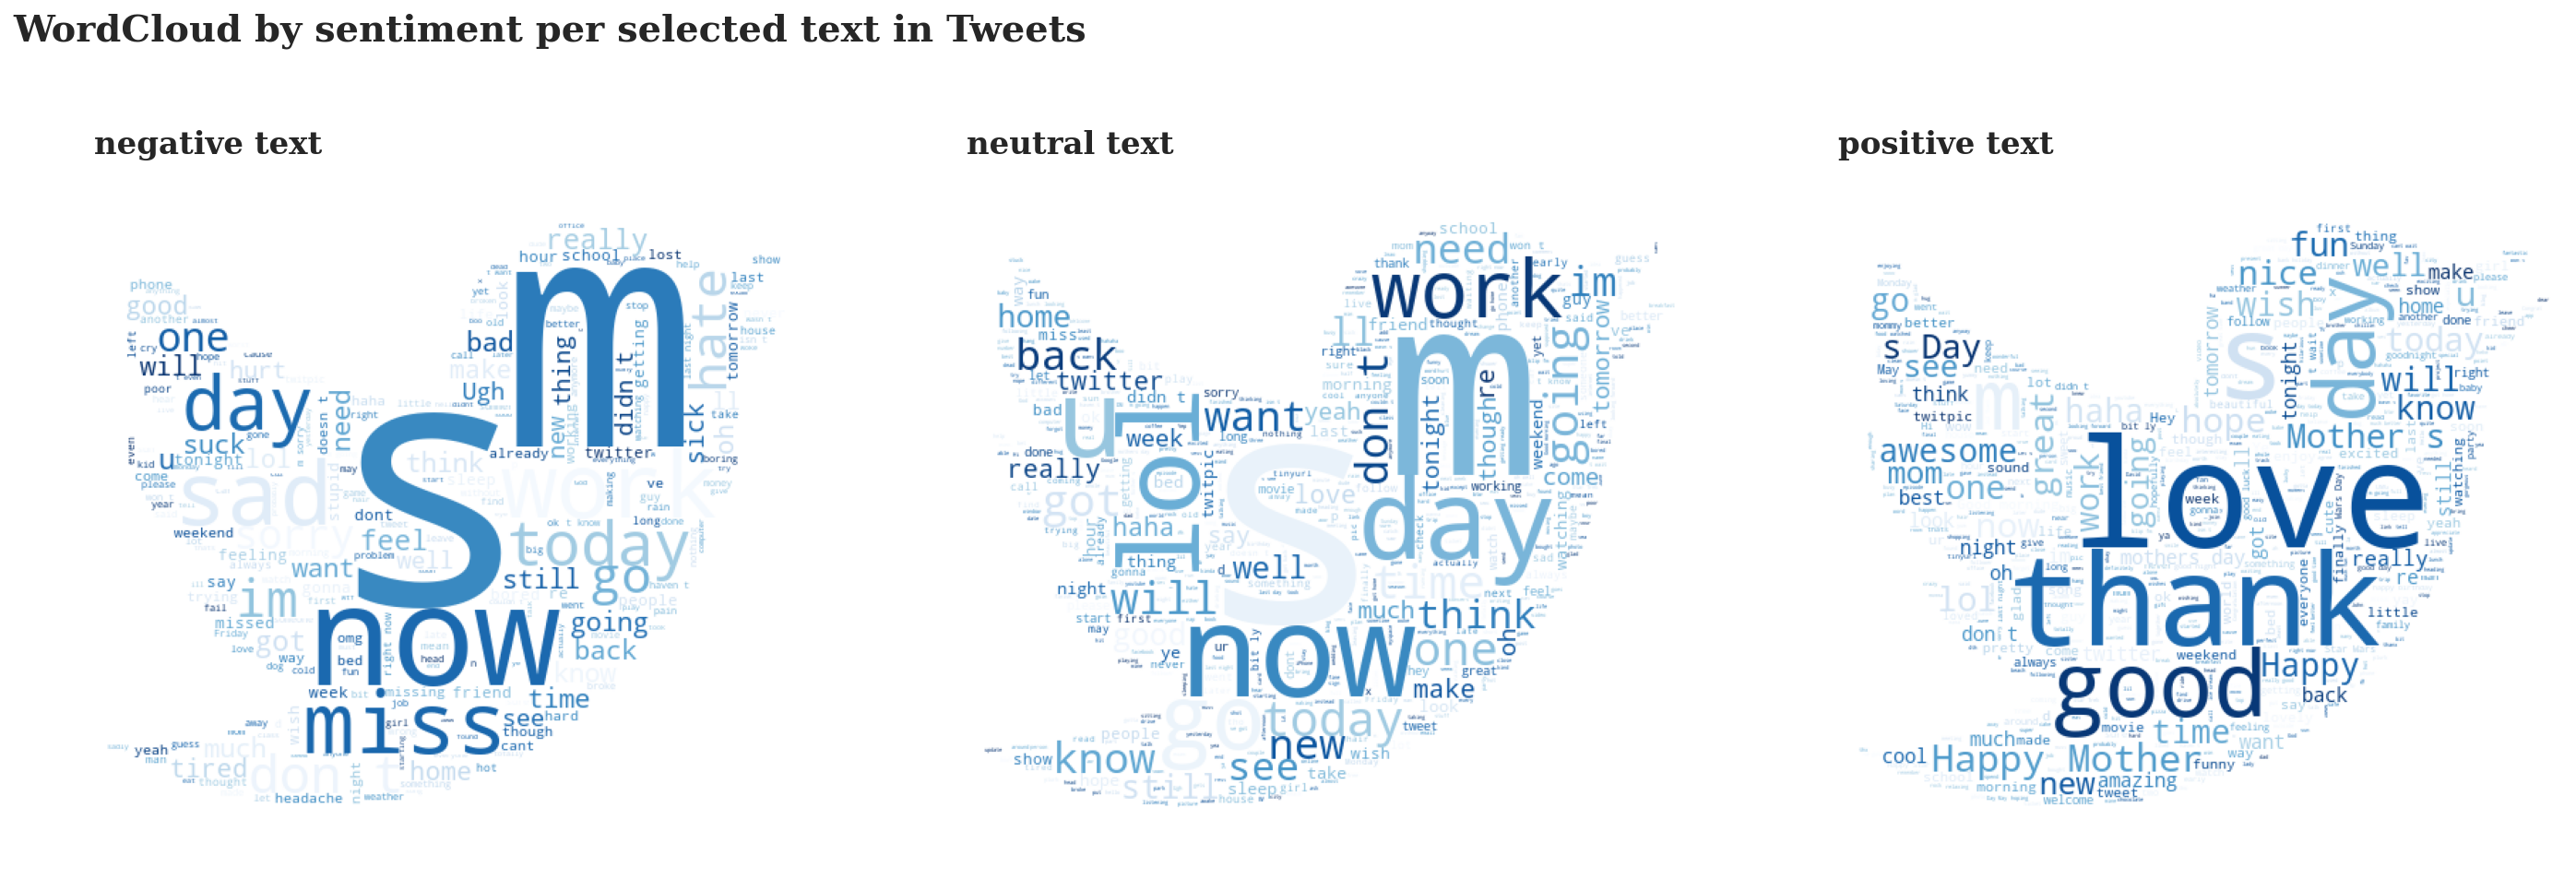

In [18]:
from wordcloud import WordCloud

fig, axes = plt.subplots(1,3, figsize=(24,12))
sentiment_list = np.unique(train_df['sentiment'])

for i, sentiment in zip(range(3), sentiment_list):
    wc = WordCloud(background_color="white", max_words = 2000, width = 1600, height = 800, mask=mask_dir, colormap="Blues").generate(" ".join(train_df[train_df['sentiment']==sentiment]['text']))
    
    axes[i].text(0.5,1, "{} text".format(sentiment), fontweight="bold", fontfamily='serif', fontsize=17)
    axes[i].patch.set_alpha(0)
    axes[i].axis('off')
    axes[i].imshow(wc)

fig.text(0.1,0.8,"WordCloud by sentiment per selected text in Tweets", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

# Cleaning text

In [1]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from wordcloud import WordCloud, STOPWORDS
import spacy

In [2]:
nlp = spacy.load('en', disable=['parser', 'ner'])

We keep the lower and upper cases because it can have an impact on the sentiment.
Removing the ponctuation was also not efficient.

After some transformation, the reviews are much cleaner, but we still have some words that we should remove, namely the stopwords. Stopwords are commonly used words (i.e. “the”, “a”, “an”) that do not add meaning to a sentence and can be ignored without having a drastic effect on the meaning of the sentence.


In [3]:
stop = stopwords.words('english')

#train_df['text'] = train_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#test_df['text'] = test_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

Lastly, we will implement lemmatization using Spacy so that we can count the appearance of each word. Lemmatization removes the grammar tense and transforms each word into its original form. Another way of converting words to its original form is called stemming. While stemming takes the linguistic root of a word, lemmatization is taking a word into its original lemma. For example, if we performed stemming on the word “apples”, the result would be “appl”, whereas lemmatization would give us “apple”. Therefore I prefer lemmatization over stemming, as its much easier to interpret.

In [4]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])

#train_df['text']= train_df['text'].apply(space)
#test_df['text']= test_df['text'].apply(space)

### URLs removal

In [6]:
# remove URL with regex
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

### Converting emojis and emoticons into words

In [12]:

from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO



In [11]:
!pip install emot


     |████████████████████████████████| 61 kB 15 kB/s  eta 0:00:011


In [15]:
import re

# Converting emojis to words
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text

# Converting emoticons to words    
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        pattern = re.escape(emot)  # Escape special characters in the emoticon
        text = re.sub(pattern, "_".join(EMOTICONS_EMO[emot].replace(",","").split()), text)
    return text

# Example
text = "Hello :x"
print(convert_emoticons(text))

text1 = "Hilarious 😂"
print(convert_emojis(text1))


#train_df['text']= train_df['text'].apply(convert_emojis)
#train_df['text']= train_df['text'].apply(convert_emoticons)

#test_df['text']= test_df['text'].apply(convert_emojis)
#test_df['text']= test_df['text'].apply(convert_emoticons)

Hello Sealed_lips_or_wearing_braces_or_tongue-tied
Hilarious face_with_tears_of_joy


### corrected words

In [16]:
!pip install pyspellchecker
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

text = "speling correctin"
print(correct_spellings(text))
text = "thnks for readin the notebook"
print(correct_spellings(text))

#train_df['text']= train_df['text'].apply(correct_spellings)
#test_df['text']= test_df['text'].apply(correct_spellings)

     |████████████████████████████████| 6.8 MB 3.0 MB/s eta 0:00:01
spelling correcting
thanks for reading the notebook


### Handling words with multiple repetition letters

In [17]:
def repetition(text):
    return re.sub("(.)\\1{3,}", "\\1", text)

#train_df['text']= train_df['text'].apply(repetition)
#test_df['text']= test_df['text'].apply(repetition)

### Chat Words Conversion

In [18]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My fuck Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The fuck
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My fuck Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The fuck
WTG=Way To Go!
WUF=Where Are You From?
WKDN=Week-End
W8=Wait...
7K=Sick Laugher
"""

chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

print(chat_words_conversion("one minute BRB"))

#train_df['text']= train_df['text'].apply(chat_words_conversion)
#test_df['text']= test_df['text'].apply(chat_words_conversion)

one minute Be Right Back


### Twitter handlers deletion

In [19]:
#train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'@mention', '', x))
#test_df['text'] = test_df['text'].apply(lambda x: re.sub(r'@mention', '', x))

### Removing numerical data

In [20]:
def remove_numbers(text):
    return re.sub('[0–9]','',text)

#train_df["text"] = train_df["text"].apply(remove_numbers)
#test_df["text"] = test_df["text"].apply(remove_numbers)

#### Removing multiple white spaces + white space at the beginning and at the end of the tweets

In [21]:
def remove_mul_white_spaces(text):
    return re.sub(' +', ' ',text).strip()

#train_df["text"] = train_df["text"].apply(remove_mul_white_spaces)
#test_df["text"] = test_df["text"].apply(remove_mul_white_spaces)

### Remove punctuation after having taken care of emoticons

In [22]:
import string

PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

#train_df["text"] = train_df["text"].apply(remove_punctuation)
#test_df["text"] = test_df["text"].apply(remove_punctuation)